# Его величество, "домашка №1"

В этой домашней работе вам предоставится уникальная возможность обучить Byte-level BPE токенизатор и небольшую LM.  

Домашняя работа состоит из нескольких последовательных блоков: реализация и обучение токенизатора, реализация Transformer модели и обучение модели на датасете с русскими анекдотами!

Обученные токенизатор и модель можно и нужно выложить на [🤗 HuggingFace](https://huggingface.co/). Зарегистрируйтесь там, подпишитесь на [deep vk](https://huggingface.co/deepvk) и создайте себе API токен.

Следуйте ячейкам тетрадки и заполняйте пропущенные ячейки. В конце тетрадки вы найдете задачи со звездочкой, чтобы получить максимальный балл!

In [2]:
# Установим необходимые дополнительные библиотеки

!pip install --quiet datasets livelossplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.0 MB/s eta 0:00:00


In [3]:
# Необходимые импорты

import inspect
import json
import os
from collections import Counter
from dataclasses import dataclass
from functools import lru_cache, partial
from pathlib import Path

import regex as re
import torch
import torch.nn as nn
from datasets import load_dataset
from huggingface_hub import HfApi, PyTorchModelHubMixin, interpreter_login, snapshot_download
from huggingface_hub.utils import SoftTemporaryDirectory
from livelossplot import PlotLosses
from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange

In [4]:
# Этой функцией будут помечены все места, которые необходимо дозаполнить
# Это могут быть как целые функции, так и отдельные части внутри них
# Всегда можно воспользоваться интроспекцией и найти места использования этой функции :)


def todo():
    stack = inspect.stack()
    caller_frame = stack[1]
    function_name = caller_frame.function
    line_number = caller_frame.lineno
    raise NotImplementedError(f"TODO at {function_name}, line {line_number}")

In [5]:
interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Enter your token (input will not be visible): ··········
Add token as git credential? (Y/n) y


In [6]:
# Подготовим репозиторий для будущей модели и токенизатора
username = HfApi().whoami()["name"]
REPO_NAME = f"{username}/llm-course-hw1"  # Или как вам хочется

print(f"Homework repository: '{REPO_NAME}'")

# И другие полезные вещи
SEED = 0xC0FFEE

Homework repository: 'xinyuema/llm-course-hw1'


# Датасет

Первым делом загрузим данные: [🤗 IgorVolochay/russian_jokes](https://huggingface.co/datasets/IgorVolochay/russian_jokes)

И немного посмотрим на них 👀

In [7]:
dataset = load_dataset("IgorVolochay/russian_jokes")
print("\n===\n".join(dataset["train"]["text"][:3]))

README.md:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

dataset.txt:   0%|          | 0.00/41.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/150553 [00:00<?, ? examples/s]

- Зять, а ты знаешь, где найти того мужчину, который спас меня, когда я тонула?- Да, он уже приходил ко мне извиняться!
===
После проведения акции "К животным по-человечески" животные посовещались и решили провести акцию "К человеку по-скотски".
===
Штирлиц пришел домой и сразу завалился на боковую. Средняя от досады заплакала.


In [8]:
# Подготовим холдауты
dataset = dataset["train"].train_test_split(test_size=0.1, seed=SEED)
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 135497
    })
    test: Dataset({
        features: ['text'],
        num_rows: 15056
    })
})

# Токенизатор [6 баллов]

В качестве токенизатора будем использоват Byte-level BPE.

Для этого:
1. Реализуем его обучения, нам необходимо построить словарь заданного размера и набор слияний по этому словарю
2. Обучим токенизатор на датасете
3. Реализуем инференс токенизатора: кодирование текста и декодирование токенов


In [9]:
# Всякие полезности

WHITESPACE_SPLITTER = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")


def bytes_to_unicode() -> dict[int, str]:
    """The original dictionary consists of 256 bytes and their corresponding Unicode characters.
    For example, chr(33) is '!'. However, not all bytes have a visually appealing representation,
    so such characters are skipped and replaced with the first available ones, i.e. shifted by 256.
    """
    initial_bytes = (
        list(range(ord("!"), ord("~") + 1)) + list(range(ord("¡"), ord("¬") + 1)) + list(range(ord("®"), ord("ÿ") + 1))
    )
    initial_chars = [chr(it) for it in initial_bytes]
    n = 0
    for byte in range(2**8):
        if byte not in initial_bytes:
            initial_bytes.append(byte)
            initial_chars.append(chr(2**8 + n))
            n += 1
    return dict(sorted(zip(initial_bytes, initial_chars)))

In [10]:
def merge(merge_pair: tuple[str, str], pair_frequences: Counter[tuple[str, str]], words_by_tokens: Counter[tuple[str]]):
    new_token = "".join(merge_pair)
    new_words = Counter()

    # Обновляем токенизацию слов
    for word_tokens, count in words_by_tokens.items():
        new_word = []
        i = 0
        while i < len(word_tokens):
            if i < len(word_tokens)-1 and (word_tokens[i], word_tokens[i+1]) == merge_pair:
                new_word.append(new_token)
                i += 2
            else:
                new_word.append(word_tokens[i])
                i += 1
        new_words[tuple(new_word)] += count

    # Пересчитываем пары
    new_pair_freq = Counter()
    for word_tokens, count in new_words.items():
        for pair in zip(word_tokens[:-1], word_tokens[1:]):
            new_pair_freq[pair] += count

    return new_pair_freq, new_words

def train(data: list[str], vocab_size: int = 1024, special_tokens: list[str] = None):
    """Train BPE tokenizer on passed data"""
    if vocab_size < 256:
        raise ValueError("Vocab size can't be less than 256")
    if special_tokens is None:
        special_tokens = []

    # 1. Initialize vocabulary (using inverse one during training)
    id2token = bytes_to_unicode()
    merges = []

    # 2. Load data
    words_by_tokens = Counter()
    for sample in tqdm(data, desc="Loading data"):
        # 2.1 Split into words
        words = WHITESPACE_SPLITTER.findall(sample.strip())
        for word in words:
            # 2.2 Tokenize with base vocabulary
            # Convert word to bytes then to Unicode characters
            byte_representation = [id2token[b] for b in word.encode('utf-8')]
            words_by_tokens[tuple(byte_representation)] += 1

    # 3. Calculate statistic of token's pairs
    pair_frequences = Counter()
    for word_tokens, count in words_by_tokens.items():
        for i in range(len(word_tokens)-1):
            pair = (word_tokens[i], word_tokens[i+1])
            pair_frequences[pair] += count

    # 4. Build vocabulary
    pbar = trange(vocab_size, desc="Building vocabulary", initial=len(id2token) + len(special_tokens))
    while len(id2token) < vocab_size - len(special_tokens):
        if len(pair_frequences) == 0:
            print("Not enough data to fulfil vocabulary")
            break

        # 4.1 Find the most frequent pair and create new token
        top_pair, _ = pair_frequences.most_common(1)[0]
        new_token = "".join(top_pair)
        del pair_frequences[top_pair]

        # 4.2 Add to vocabulary
        if new_token in id2token.values():
            continue
        id2token[len(id2token)] = new_token
        merges.append(top_pair)

        # 4.3 Update stats and merge the top pair in all tokens
        pair_frequences, words_by_tokens = merge(top_pair, pair_frequences, words_by_tokens)

        pbar.update()
    pbar.close()

    # 5. Add special tokens
    for special_token in special_tokens:
        id2token[len(id2token)] = special_token

    return {v: k for k, v in id2token.items()}, merges

In [11]:
# Обучаем токенизатор на тренировочных текстах
# Для нашей задачи хватит и небольшого словаря, но можете пробовать и большего размера обучить!


vocab, merges = train(dataset["train"]["text"], vocab_size=1024, special_tokens=["[EOS]"])

Loading data:   0%|          | 0/135497 [00:00<?, ?it/s]

Building vocabulary:  25%|##5       | 257/1024 [00:00<?, ?it/s]

In [12]:
# Посмотрим на случайные токены

random_tokens = [512, 614, 768, 888, 1022]
unicode_to_bytes = {v: k for k, v in bytes_to_unicode().items()}
for token_id in random_tokens:
    token = [k for k, v in vocab.items() if v == token_id][0]
    raw_bytes = bytes([unicode_to_bytes[it] for it in token])
    print(f"Token #{token_id}: '{raw_bytes.decode('utf-8', errors='replace')}'")

Token #512: ' Я'
Token #614: ' уже'
Token #768: ' Нет'
Token #888: ' него'
Token #1022: ' голов'


In [13]:
class ByteLevelBPETokenizer:

    def __init__(self, vocab: dict[str, int], merges: list[tuple[str, str]], eos_token: str = "[EOS]"):
        """Byte-Level BPE Tokenizer

        Args:
            vocab: mapping from string token to id
            merges: list of merges in prioritized order
            eos_token: string representation of EOS token
        """
        super().__init__()
        if eos_token not in vocab:
            raise ValueError("There is no EOS token in vocab")
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        self.token2id = vocab
        self.id2token = {v: k for k, v in self.token2id.items()}
        self.eos_token = eos_token
        self.eos_token_id = self.token2id[eos_token]

        # The closer the pair is to the beginning, the higher the rank
        self.merges = merges
        self.bpe_ranks = {pair: i for i, pair in enumerate(merges)}

    @lru_cache
    def bpe(self, word: tuple[str]) -> tuple[str]:
        """Process word into tokenized representation.
        Word is a tuple of base tokens, i.e. bytes.

        Under the hood:
        1. Tracks the set of token pairs, bi-grams
        2. While possible, replaces the highest-ranking pair with its union

        Args:
            word: list of base string tokens
        Return:
            list of BPE tokens
        """
        pairs = set(zip(word[:-1], word[1:]))
        if not pairs:
            return word

        while True:
            min_rank = float('inf')
            merge_candidate = None
            for pair in pairs:
                rank = self.bpe_ranks.get(pair, None)
                if rank is not None and rank < min_rank:
                    min_rank = rank
                    merge_candidate = pair

            if merge_candidate is None:
                break

            first, second = merge_candidate
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except ValueError:
                    new_word.extend(word[i:])
                    break

                if i < len(word)-1 and word[i] == first and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1

            word = tuple(new_word)
            pairs = set(zip(word[:-1], word[1:]))

        return word

    def encode(self, text: str, add_eos_token: bool = True) -> list[int]:
        """Convert string to list of token ids.

        Args:
            text: input string, may contain multiple words
            add_eos_token: whether to add eos token id at the end
        Return:
            list of ints, ids of tokenized text
        """
        words = WHITESPACE_SPLITTER.findall(text)
        token_ids = []
        for word in words:
            word_bytes = word.encode('utf-8')
            encoded_word = tuple(self.byte_encoder[b] for b in word_bytes)
            bpe_tokens = self.bpe(encoded_word)
            token_ids.extend(self.token2id[token] for token in bpe_tokens)

        if add_eos_token:
            token_ids.append(self.eos_token_id)

        return token_ids

    def decode(self, idx: list[int]) -> str:
        """Convert list of tokens' ids to text, opposite to encode method

        Args:
            idx: list of tokens' ids
        Return:
            string, decoded text
        """
        tokens = [self.id2token[i] for i in idx if i != self.eos_token_id]
        text_bytes = bytearray()
        for token in tokens:
            bytes_seq = [self.byte_decoder[c] for c in token]
            text_bytes.extend(bytes_seq)
        return text_bytes.decode('utf-8', errors='replace')

    def push_to_hub(self, repo_id, *, private=None, token=None):
        api = HfApi()
        repo_id = api.create_repo(repo_id=repo_id, token=token, private=private, exist_ok=True).repo_id

        # Push the files to the repo in a single commit
        with SoftTemporaryDirectory() as tmp:
            save_directory = Path(tmp) / repo_id
            save_directory.mkdir(parents=True)
            with open(save_directory / "vocabulary.json", "w") as f_out:
                print(json.dumps(self.token2id, indent=2), file=f_out)
            with open(save_directory / "merges.json", "w") as f_out:
                print(json.dumps({"merges": self.merges}), file=f_out)

            return api.upload_folder(repo_id=repo_id, folder_path=save_directory, token=token)

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, *, token=None, **model_kwargs):
        if not os.path.isdir(pretrained_model_name_or_path):
            storage_folder = snapshot_download(repo_id=pretrained_model_name_or_path, token=token)
        else:
            storage_folder = pretrained_model_name_or_path
        storage_folder = Path(storage_folder)
        with open(storage_folder / "vocabulary.json", "r") as f_in:
            vocab = json.load(f_in)
        with open(storage_folder / "merges.json", "r") as f_in:
            merges = [tuple(it) for it in json.load(f_in)["merges"]]
        return cls(vocab, merges, **model_kwargs)

In [14]:
# Инициализируем токенизатор


tokenizer = ByteLevelBPETokenizer(vocab, merges)

In [15]:
# Загружаем токенизатор на хаб

tokenizer.push_to_hub(REPO_NAME)

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/xinyuema/llm-course-hw1/commit/200e40cee2fc62dfa5c4874f7a29562e44accd56', commit_message='Upload folder using huggingface_hub', commit_description='', oid='200e40cee2fc62dfa5c4874f7a29562e44accd56', pr_url=None, repo_url=RepoUrl('https://huggingface.co/xinyuema/llm-course-hw1', endpoint='https://huggingface.co', repo_type='model', repo_id='xinyuema/llm-course-hw1'), pr_revision=None, pr_num=None)

In [16]:
# Скачиваем токенизатор с хаба

tokenizer = ByteLevelBPETokenizer.from_pretrained(REPO_NAME)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

vocabulary.json:   0%|          | 0.00/37.7k [00:00<?, ?B/s]

merges.json:   0%|          | 0.00/33.1k [00:00<?, ?B/s]

In [17]:
# Смотрим на работу токенизатора

text = "Что было полгода назад? Помимо грандиозных событий, полгода назад были ещё семинары по линейной алгебре."
ids = tokenizer.encode(text)
print(ids)
reverse_text = [tokenizer.decode([it]) for it in ids]
print("|".join(reverse_text))
print(tokenizer.decode(ids))

[795, 282, 755, 481, 350, 305, 258, 276, 337, 358, 63, 357, 302, 362, 257, 330, 617, 769, 419, 634, 658, 782, 406, 44, 481, 350, 305, 258, 276, 337, 358, 398, 361, 339, 336, 865, 277, 323, 316, 338, 272, 380, 345, 316, 372, 503, 349, 279, 350, 391, 264, 259, 46, 1023]
Ч|то| было| пол|г|од|а| н|аз|ад|?| П|ом|им|о| г|ран|ди|оз|ных| соб|ыт|ий|,| пол|г|од|а| н|аз|ад| бы|ли| е|щ|ё| с|ем|ин|ар|ы| по| л|ин|ей|ной| а|л|г|еб|р|е|.|
Что было полгода назад? Помимо грандиозных событий, полгода назад были ещё семинары по линейной алгебре.


In [18]:
# Посчитаем немного статистики по токенизации, определимся с размером контекста у модели

lens = []
for text in tqdm(dataset["test"]["text"]):
    ids = tokenizer.encode(text)
    lens.append(len(ids))

print(f"Average token len per sample: {sum(lens) / len(lens):.2f}")
print(f"Minimum and maximum lens are: {min(lens)} and {max(lens)}")

  0%|          | 0/15056 [00:00<?, ?it/s]

Average token len per sample: 70.42
Minimum and maximum lens are: 5 and 3324


Должно получиться в среднем по 70 токенов на последовательность.
Контекста в 128 токенов будет вполне достаточно.

# Модель [10 баллов]

В качестве модели реализуем трансформер, в котором
1. В качестве позиционных эмбеддингов используется ALiBi
2. Механизм внимания использует GQA
3. В Feed-Forward блоке SwiGLU

In [19]:
# Для удобства заведем конфиг для модели


@dataclass
class TransformerConfig:
    n_layer: int
    n_head: int
    n_kv_head: int
    hidden_dim: int
    intermediate_dim: int
    dropout: float = 0.1
    vocab_size: int = 1024
    max_seq_len: int = 128


model_configs = {
    "nano": TransformerConfig(n_layer=3, n_head=4, n_kv_head=2, hidden_dim=96, intermediate_dim=256),
    "mini": TransformerConfig(n_layer=6, n_head=6, n_kv_head=3, hidden_dim=384, intermediate_dim=1024),
    "small": TransformerConfig(n_layer=12, n_head=12, n_kv_head=6, hidden_dim=768, intermediate_dim=2048),
}

In [20]:
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        """Root Mean Square Layer Normalization

        Args:
            dim: Feature dimension
            eps: Small constant for numerical stability
        """
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))

    def forward(self, x: Tensor) -> Tensor:
        rms = torch.sqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        return self.scale * (x / rms)


class CausalSelfAttention(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Causal Self-Attention with support of
        Grouped-Query Attention and ALiBi for positional encoding
        """
        super().__init__()
        self.config = config
        assert self.config.hidden_dim % self.config.n_head == 0
        assert self.config.n_head % self.config.n_kv_head == 0
        self.head_dim = self.config.hidden_dim // self.config.n_head
        self.scale = self.head_dim**-0.5
        self.q_per_kv = self.config.n_head // self.config.n_kv_head

        # Init projection layers
        self.q_proj = nn.Linear(config.hidden_dim, config.n_head * self.head_dim, bias=False)
        self.kv_proj = nn.Linear(config.hidden_dim, 2 * config.n_kv_head * self.head_dim, bias=False)
        self.out_proj = nn.Linear(config.hidden_dim, config.hidden_dim, bias=False)

        self.attn_dropout = nn.Dropout(self.config.dropout)

        self.register_buffer("causal_mask", self._create_causal_mask(self.config.max_seq_len))
        self.register_buffer("alibi", self._build_alibi_bias(self.config.n_head))

    def _build_alibi_bias(self, num_heads: int) -> Tensor:
        """Build ALiBi for specified number of heads:

        Returns:
            Tensor with ALiBi biases, shape: [1, num heads, 1, 1]
        """
        return torch.tensor([(2 ** (-i * 8 / num_heads)) for i in range(num_heads)]).view(1, num_heads, 1, 1)

    def _create_causal_mask(self, max_seq_len: int) -> Tensor:
        """Create causal mask with ones where tokens can attend to each other.

        Returns:
            Tensor with causal mask, shape: [1, 1, seq len, seq len]
        """
        return torch.tril(torch.ones(max_seq_len, max_seq_len)).bool()[None, None]

    def forward(self, x: Tensor, attention_mask: Tensor = None) -> Tensor:
        """Apply Self-Attention to input data with respect to pad tokens.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
            attention_mask: mask with zeros for pad tokens, shape [bs, seq len, hidden dim]
        Returns:
            result tensor, shape [bs, seq len, hidden dim]
        """
        B, T, C = x.size()

        q = self.q_proj(x).view(B, T, self.config.n_head, self.head_dim).transpose(1,2)  # [B, n_head, T, head_dim]
        kv = self.kv_proj(x).view(B, T, self.config.n_kv_head, 2, self.head_dim)
        k, v = kv[..., 0, :], kv[..., 1, :]  # [B, T, n_kv_head, head_dim]
        k = k.transpose(1,2)  # [B, n_kv_head, T, head_dim]
        v = v.transpose(1,2)  # [B, n_kv_head, T, head_dim]

        if self.config.n_kv_head != self.config.n_head:
            k = k.repeat_interleave(self.q_per_kv, dim=1)  # [B, n_head, T, head_dim]
            v = v.repeat_interleave(self.q_per_kv, dim=1)

        attn_scores = (q @ k.transpose(-2, -1)) * self.scale  # [B, n_head, T, T]

        position_ids = torch.arange(T, device=x.device)
        rel_pos = position_ids[:, None] - position_ids[None]
        attn_scores = attn_scores - (self.alibi * rel_pos.unsqueeze(0))

        causal_mask = self.causal_mask[:, :, :T, :T]
        attn_scores = attn_scores.masked_fill(~causal_mask, float('-inf'))

        if attention_mask is not None:
            extended_mask = attention_mask[:, None, None, :].to(torch.bool)  # [B, 1, 1, T]
            attn_scores = attn_scores.masked_fill(~extended_mask, float('-inf'))

        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)

        attn_output = attn_weights @ v  # [B, n_head, T, head_dim]
        attn_output = attn_output.transpose(1,2).contiguous().view(B, T, C)

        return self.out_proj(attn_output)


class SwiGLU(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Gated Liner Unit with Swish Activation"""
        super().__init__()
        self.config = config
        self.fc1 = nn.Linear(config.hidden_dim, 2 * config.intermediate_dim)
        self.fc2 = nn.Linear(config.intermediate_dim, config.hidden_dim)

    def forward(self, x: Tensor) -> Tensor:
        """Apply SwiGLU to input data.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
        Returns:
            result tensor, shape [bs, seq len, hidden dim]
        """
        x_proj, gate = self.fc1(x).chunk(2, dim=-1)
        return self.fc2(gate * torch.sigmoid(gate) * x_proj)


class Block(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Base Transformer Block
        - Causal Self-Attention and SwiGLU as main elements
        - Pre-normalization via RMSNorm
        - Regularization with dropouts before residuals
        """
        super().__init__()
        self.ln_1 = RMSNorm(config.hidden_dim)
        self.res_dropout_1 = nn.Dropout(config.dropout)
        self.attn = CausalSelfAttention(config)

        self.ln_2 = RMSNorm(config.hidden_dim)
        self.res_dropout_2 = nn.Dropout(config.dropout)
        self.mlp = SwiGLU(config)

    def forward(self, x: Tensor, attention_mask: Tensor = None) -> Tensor:
        """Apply Transformer Block to input data.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
            attention_mask: mask with zeros for pad tokens, shape [bs, seq len, hidden dim]
        Returns:
            result tensor, shape [bs, seq len, hidden dim]
        """
        x_residual = x
        x = self.ln_1(x)
        x = self.attn(x, attention_mask=attention_mask)
        x = self.res_dropout_1(x)
        x = x + x_residual

        # MLP Block with pre-norm and residual
        x_residual = x
        x = self.ln_2(x)
        x = self.mlp(x)
        x = self.res_dropout_2(x)
        x = x + x_residual

        return x


class TransformerForCausalLM(nn.Module, PyTorchModelHubMixin):
    def __init__(self, config: TransformerConfig):
        """Transformer model for Language Modeling"""
        super().__init__()
        self.vocab_size = config.vocab_size
        self.max_seq_len = config.max_seq_len
        self.n_layer = config.n_layer
        self.n_head = config.n_head
        self.hidden_dim = config.hidden_dim
        self.dropout = config.dropout

        self.token_emb = nn.Embedding(config.vocab_size, config.hidden_dim)
        self.emb_dropout = nn.Dropout(config.dropout)
        self.layers = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_final = RMSNorm(config.hidden_dim)
        self.lm_head = nn.Linear(config.hidden_dim, config.vocab_size, bias=False)

        self.apply(self._init_weights)

        n_params = sum(p.numel() for p in self.parameters())
        print(f"Number of parameters: {n_params / 1e6:.2f}M")

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, RMSNorm):
            torch.nn.init.ones_(module.scale)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor = None) -> Tensor:
        """Calculate logits for given input ids.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
            attention_mask: mask with zeros for pad tokens, shape [bs, seq len, hidden dim]
        Returns:
            logits, shape [bs, seq len, hidden dim]
        """
        x = self.token_emb(input_ids)  # [B, T, hidden_dim]
        x = self.emb_dropout(x)

        for layer in self.layers:
            x = layer(x, attention_mask=attention_mask)

        x = self.ln_final(x)
        logits = self.lm_head(x)

        return logits

    @torch.inference_mode()
    def generate(
        self, idx: Tensor, max_new_tokens, eos_token_id, temperature=1.0, do_sample=False, top_k=None
    ) -> Tensor:
        """Take a conditioning sequence of indices and complete the sequence max_new_tokens times,
        feeding the predictions back into the model each time.

        Args:
            idx: tensor with conditional tokens, shape [seq len]
            max_new_tokens: maximum number of new tokens
            eos_token_id: index of EOS token to stop generation
            temperature, do_sample, top_k: generation parameters
        Return:
            tensor with generated indexes
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.shape[1] <= self.max_seq_len else idx[:, -self.max_seq_len :]
            logits = self(idx_cond)
            logits = logits[:, -1, :] / temperature  # [bs, vocab_size]
            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                mask = logits < v[:, [-1]]
                logits[mask] = -float("inf")

            probs = F.softmax(logits, dim=-1)  # [bs, vocab_size]

            if do_sample:
                idx_next = torch.multinomial(probs, num_samples=1)  # [bs, 1]
            else:
                idx_next = torch.argmax(probs,dim=-1, keepdim=True)  # [bs, 1]

            idx = torch.cat((idx, idx_next), dim=1)
            if idx_next == eos_token_id:
                break
        return idx

# Train Loop [2 + 2 балла]

Настало время обучать модель.
Небольшую можно пробовать обучать локально, но лучше всего воспользоваться GPU, например, на Google Colab.

За реализацию 2 балла, и еще 2 балла - если модель научилась генерить анекдоты.

Не забудьте проверить, что вы загрузили нужные веса на HF и у проверяющего скачается нужная версия.

In [21]:
# Определим датасет и как заворачивать семплы в батч
# Разные тексты имеют разную длину, поэтому будет падить до самого длина семпла
# Так же заведем дополнительную маску, чтобы механизм внимания не учитывал падинги


class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer):
        self.texts = texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        texts = self.texts[idx]
        tokenized_sequence = self.tokenizer.encode(texts)
        return tokenized_sequence


def data_collator(
    tokenized_sequences: list[list[int]], pad_token_id: int, max_seq_len: int = None
) -> tuple[torch.Tensor, torch.Tensor]:
    batch_size = len(tokenized_sequences)
    max_batch_seq_len = min(max_seq_len, max((len(it) for it in tokenized_sequences)))

    input_ids = torch.full((batch_size, max_batch_seq_len), pad_token_id)
    attention_mask = torch.zeros((batch_size, max_batch_seq_len))

    for i, tok_seq in enumerate(tokenized_sequences):
        cur_len = min(len(tok_seq), max_batch_seq_len)
        input_ids[i, :cur_len] = torch.tensor(tok_seq[:cur_len])
        attention_mask[i, :cur_len] = 1

    return input_ids, attention_mask


def create_dataloader(dataset, pad_token_id, max_seq_len, batch_size, is_train):
    collate_fn = partial(data_collator, pad_token_id=pad_token_id, max_seq_len=max_seq_len)
    return DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train, drop_last=is_train, collate_fn=collate_fn, pin_memory=True
    )


_d = TextDataset(["Привет!", "Как твои дела?", "Осталось совсем немного до конца"], tokenizer)
_dl = create_dataloader(_d, tokenizer.eos_token_id, max_seq_len=16, batch_size=2, is_train=False)

for i, batch in enumerate(_dl):
    print(f"Batch #{i}")
    input_ids, attn_mask = batch
    print(input_ids, attn_mask, sep="\n\n")

Batch #0
tensor([[ 753,  347,  281,   33, 1023, 1023, 1023, 1023],
        [ 530,  304, 1012,  261,  577,  258,   63, 1023]])

tensor([[1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])
Batch #1
tensor([[ 496,  294,  298,  645,  827,  263,  323,  276,  323,  531,  693,  598,
          881, 1023]])

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [22]:
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    """Scheduler for Optimizer with linear warmup and linear decay to the end of training

    Args:
        optimizer: torch optimizer to control learning rate
        num_warmup_steps: number of warmup steps
        num_training_steps: total number of training steps
    Return:
        torch learning rate scheduler
    """
    assert num_training_steps >= num_warmup_steps

    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / max(1, num_warmup_steps)
        else:
            return max(
                0.0,
                float(num_training_steps - current_step) / max(1, num_training_steps - num_warmup_steps)
            )

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


def cross_entropy_loss(input_ids: Tensor, attention_mask: Tensor, logits: Tensor) -> Tensor:
    """Calculate Cross-Entropy loss for Language Modeling task
    Under the hood:
    1. Create targtes based on input ids
    2. Masked out tokens corresponded to paddings
    3. Calculate cross entropy loss

    Args:
        input_ids: tensor with input ids, shape [bs, seq len]
        attention_mask: mask with zeros for pad tokens, shape [bs, seq len]
        logits: predicted logits, shape [bs, seq len, vocab size]
    Return:
        cross entropy loss, single-item tensor
    """
    shift_logits = logits[:, :-1, :].contiguous()
    shift_targets = input_ids[:, 1:].contiguous()
    shift_mask = attention_mask[:, 1:].contiguous()

    loss_fct = nn.CrossEntropyLoss(reduction='none') # no reduction yet
    loss = loss_fct(shift_logits.view(-1, logits.size(-1)), shift_targets.view(-1))
    loss = loss.view(shift_targets.size())

    loss = loss * shift_mask
    loss = loss.sum() / shift_mask.sum()
    return loss

In [23]:
# Определим тренера с наиболее важными гиперпараметрами для обучения


class Trainer:

    def __init__(
        self,
        learning_rate=3e-4,
        weight_decay=0.01,
        clip_grad_norm=1.0,
        n_steps=10_000,
        val_every_n_steps=1_000,
        plot_every_n_steps=100,
    ):
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.clip_grad_norm = clip_grad_norm
        self.n_steps = n_steps
        self.val_every_n_steps = val_every_n_steps
        self.plot_every_n_steps = plot_every_n_steps

        if torch.cuda.is_available():
            self.device = "cuda"
        elif torch.backends.mps.is_available():
            self.device = "mps"
        else:
            self.device = "cpu"
        print("running on device", self.device)

    @torch.no_grad()
    def validate(self, model, val_loader):
        model.eval()
        val_loss = 0.0
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            input_ids, attention_mask = batch
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)

            logits = model(input_ids, attention_mask)  # [bs; seq len; vocab size]
            val_loss += cross_entropy_loss(input_ids, attention_mask, logits)
        return val_loss / len(val_loader)

    def run(self, model, train_loader, val_loader):
        model = model.to(self.device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=0.1 * self.n_steps, num_training_steps=self.n_steps
        )
        model.train()

        plotlosses = PlotLosses(figsize=(15, 9), step_names="Step")
        logs = {"lr": 0, "epoch": 0}

        data_iter = iter(train_loader)
        for iter_num in range(self.n_steps):
            try:
                batch = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                logs["epoch"] += 1
                batch = next(data_iter)

            input_ids, attention_mask = batch
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)

            logits = model(input_ids, attention_mask)  # [bs; seq len; vocab size]
            loss = cross_entropy_loss(input_ids, attention_mask, logits)

            # backprop and update the parameters
            model.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), self.clip_grad_norm)
            optimizer.step()
            scheduler.step()

            if iter_num > 0 and iter_num % self.val_every_n_steps == 0:
                val_loss = self.validate(model, val_loader)
                plotlosses.update({"val_loss": val_loss.item()}, current_step=iter_num)
                plotlosses.send()
                model.train()

            if iter_num % self.plot_every_n_steps == 0:
                logs["loss"] = loss.item()
                logs["lr"] = scheduler.get_last_lr()[0]
                plotlosses.update(logs, current_step=iter_num)
                plotlosses.send()

        val_loss = self.validate(model, val_loader)
        plotlosses.update({"val_loss": val_loss.item()}, current_step=iter_num)
        plotlosses.send()

In [24]:
# Создаем тренировочный и тестовые даталоадеры


MAX_SEQ_LEN = 128
BATCH_SIZE = 16

train_dataset = TextDataset(dataset["train"]["text"], tokenizer)
train_dataloader = create_dataloader(
    train_dataset, tokenizer.eos_token_id, max_seq_len=MAX_SEQ_LEN, batch_size=BATCH_SIZE, is_train=True
)

test_dataset = TextDataset(dataset["test"]["text"], tokenizer)
test_dataloader = create_dataloader(
    test_dataset, tokenizer.eos_token_id, max_seq_len=MAX_SEQ_LEN, batch_size=BATCH_SIZE, is_train=False
)

In [25]:
# Инициализируем модель

config = model_configs["small"]
model = TransformerForCausalLM(config)

Number of parameters: 79.51M


In [26]:
# Инициализируем тренера

trainer = Trainer(learning_rate=3e-4)

running on device cuda


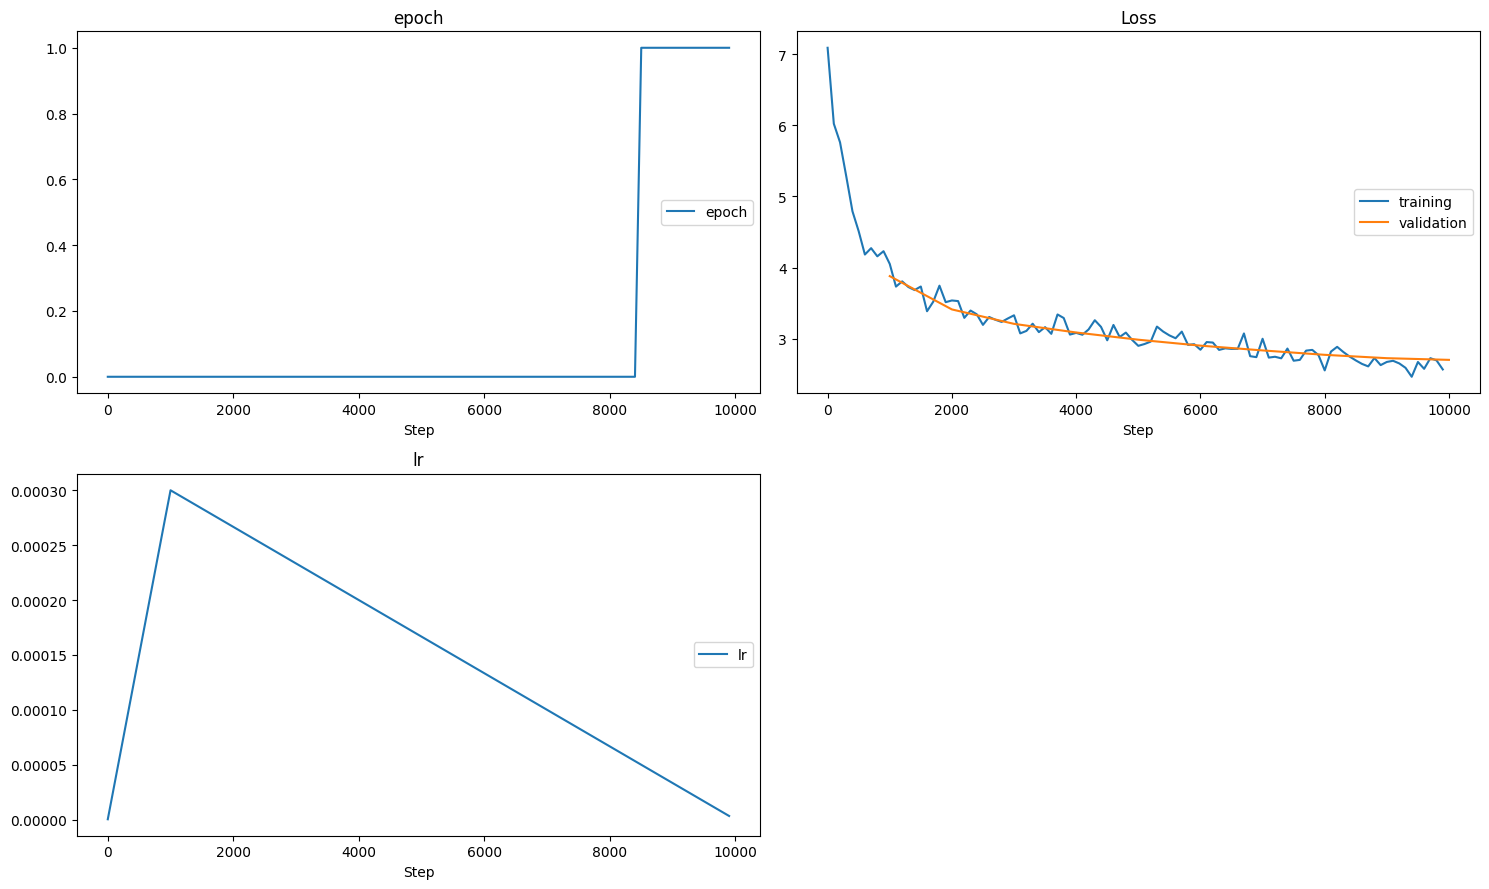

epoch
	epoch            	 (min:    0.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    2.467, max:    7.088, cur:    2.570)
	validation       	 (min:    2.705, max:    3.881, cur:    2.705)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)


In [27]:
# Обучение goes brrrr!

trainer.run(model, train_dataloader, test_dataloader)

In [28]:
# Смотрим на качество генерации глазами
# Для маленьких и слабых моделей "затягиваем" гайки генерации

text = "Заходит в бар"
input_ids = torch.tensor(tokenizer.encode(text)[:-1], device=trainer.device)[None, :]
print(input_ids)
model_output = model.generate(
    input_ids, max_new_tokens=200, eos_token_id=tokenizer.eos_token_id, do_sample=True, top_k=10
)
tokenizer.decode(model_output[0].tolist())

tensor([[730, 258, 620, 275, 303, 338]], device='cuda:0')


'Заходит в бар, встает и говорит жене:- Спасибо, доктор, я буду жить в месяц!- А какой я тебя пить?'

In [29]:
# Смотрим на качество генерации глазами
# Для маленьких и слабых моделей "затягиваем" гайки генерации

text = "Заходит в бар"
input_ids = torch.tensor(tokenizer.encode(text)[:-1], device=trainer.device)[None, :]
print(input_ids)
model_output = model.generate(
    input_ids, max_new_tokens=200, eos_token_id=tokenizer.eos_token_id, do_sample=True, top_k=10
)
tokenizer.decode(model_output[0].tolist())

tensor([[730, 258, 620, 275, 303, 338]], device='cuda:0')


'Заходит в бар в ресторан, а там - американская кампания. После обезьяны с кабинетом студента входит панк и, ну тогда впервые выходит в магазинах в костр и говорит: - А я - генерал! Тот сдает пальцем, и говорит: - Я - воскресенье! После трого: - Пошли куда вы находить? - Вообще-то мальчики сегодня встретятся: - Тогда я буду котенка с копейки.'

In [30]:
# Загружаем модель на хаб

model.push_to_hub(REPO_NAME)

model.safetensors:   0%|          | 0.00/318M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/xinyuema/llm-course-hw1/commit/2c037ba2722e6ac6256075598ef4950c80e16bb4', commit_message='Push model using huggingface_hub.', commit_description='', oid='2c037ba2722e6ac6256075598ef4950c80e16bb4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/xinyuema/llm-course-hw1', endpoint='https://huggingface.co', repo_type='model', repo_id='xinyuema/llm-course-hw1'), pr_revision=None, pr_num=None)

# Специальный раздел для проверяющего

In [33]:
device = torch.device("cuda")

tokenizer = ByteLevelBPETokenizer.from_pretrained(REPO_NAME)
check_model = TransformerForCausalLM.from_pretrained(REPO_NAME)
check_model = check_model.to(device)
check_model = check_model.eval()

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/164 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/318M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/320 [00:00<?, ?B/s]

Number of parameters: 79.51M


In [34]:
text = "Штирлиц пришел домой"
input_ids = torch.tensor(tokenizer.encode(text), device=device)
model_output = check_model.generate(
    input_ids[None, :], max_new_tokens=200, eos_token_id=tokenizer.eos_token_id, do_sample=True, top_k=10
)
tokenizer.decode(model_output[0].tolist())

'Штирлиц пришел домой. Подходит к стройке.- Скорее всего лишь бы?- Петрович, в шубу.- А я вчера съездила!- Так ведь это не квадратный!'